In [128]:
!pip3 install tensorflow
!pip3 install kagglehub


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [129]:
import kagglehub
import os
import pandas as pd
import numpy as np

In [ ]:
file_path = os.path.join("wre.us.txt")
df = pd.read_csv(file_path)

# Extraer encabezados
header = df.columns.tolist()
price = df["Close"].to_numpy()             
raw_data = df.iloc[:, 1:].to_numpy() 


         Date    Open    High     Low   Close  Volume  OpenInt
0  2005-02-25  20.959  21.410  20.959  21.410  229331        0
1  2005-02-28  21.300  21.350  20.849  21.211  207446        0
2  2005-03-01  21.286  21.429  21.009  21.336  264983        0
3  2005-03-02  21.170  21.562  21.069  21.227  177574        0
4  2005-03-03  21.320  21.444  21.124  21.436  122100        0
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'], dtype='object')


# Punto 1
## Parsing Data



In [149]:
import numpy as np
price_high = df["High"].to_numpy()
price_low = df["Low"].to_numpy()
price = (price_high + price_low) / 2

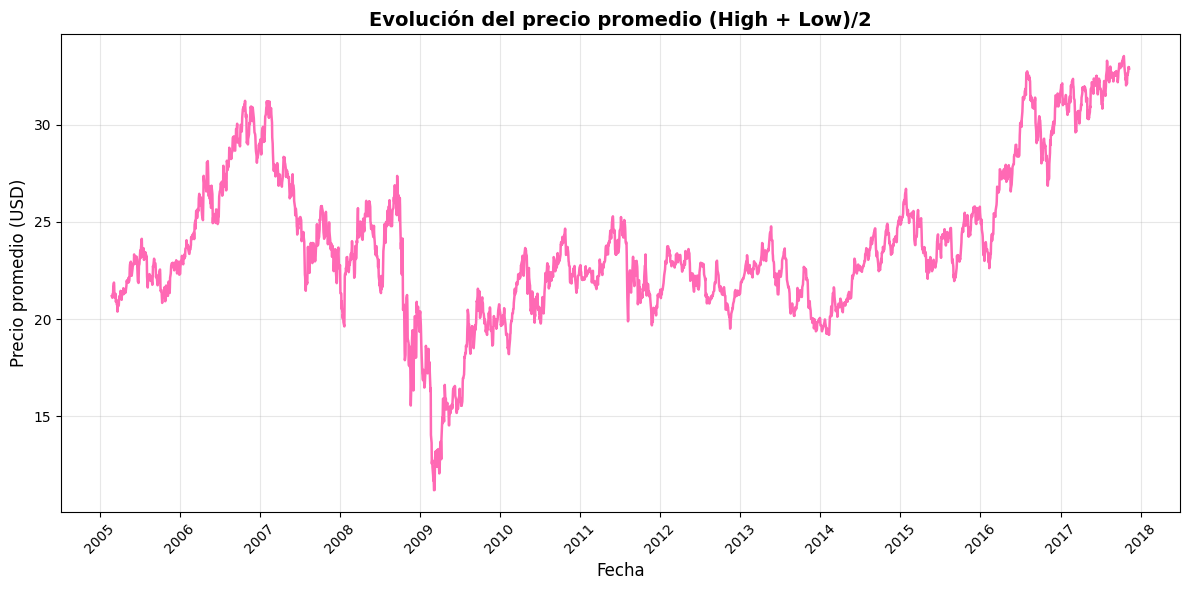

In [150]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convertir la columna 'Date' a formato de fecha
df["Date"] = pd.to_datetime(df["Date"])

plt.figure(figsize=(12,6))
plt.plot(df["Date"], price, color='hotpink', linewidth=1.8)

# Título y etiquetas
plt.title("Evolución del precio promedio (High + Low)/2", fontsize=14, weight='bold')
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Precio promedio (USD)", fontsize=12)

# Formato del eje X para fechas
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))       
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y")) 

# Rotar etiquetas y ajustar estilo
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Normalization

In [152]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 1600
num_val_samples: 800
num_test_samples: 801


In [151]:
print("¿Hay NaN en raw_data?:", np.isnan(raw_data).any())
print("¿Hay inf en raw_data?:", np.isinf(raw_data).any())
std = raw_data[:num_train_samples].std(axis=0)
print("Mínimo std:", np.min(std))

¿Hay NaN en raw_data?: False
¿Hay inf en raw_data?: False
Mínimo std: 0.0


In [135]:

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)

# Verificar columnas con std = 0
constant_cols = np.where(std == 0)[0]
column_names = df.columns[1:]
print("Columnas constantes:", column_names[constant_cols])
print("Número de columnas constantes:", len(constant_cols))

std[std == 0] = 1 
raw_data /= std


Columnas constantes: Index(['OpenInt'], dtype='object')
Número de columnas constantes: 1


In [136]:
import numpy as np
from tensorflow import keras
from keras import layers

In [137]:


sequence_length = 30  
sampling_rate = 1    
delay = 1             
batch_size = 32

# Dataset de entrenamiento
train_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=price[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    shuffle=False,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

# Dataset de validación
val_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=price[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

# Dataset de prueba
test_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=price[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)


In [138]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (32, 30, 6)
targets shape: (32,)


# Punto 2

In [145]:
use_recurrent_dropout = True
dropout_rate = 0.2 

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16,  recurrent_dropout=dropout_rate if use_recurrent_dropout else 0)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("wre.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("wre.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 522.1695 - mae: 22.5648 - val_loss: 433.4758 - val_mae: 20.7894
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 450.6126 - mae: 20.9442 - val_loss: 349.5501 - val_mae: 18.6581
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 385.0735 - mae: 19.3000 - val_loss: 298.4593 - val_mae: 17.2326
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 332.2386 - mae: 17.8584 - val_loss: 258.3768 - val_mae: 16.0276
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 291.1954 - mae: 16.6537 - val_loss: 226.0228 - val_mae: 14.9843
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 258.1933 - mae: 15.6180 - val_loss: 198.6089 - val_mae: 14.0398
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 230.2677 - mae: 14.6815 - val_loss: 174.5155 - val_mae: 13.1538
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 204.4312 - mae: 13.7813 - val_loss: 152.7688 - val_mae: 12.2994
Epoch 9/50
50/50 ━

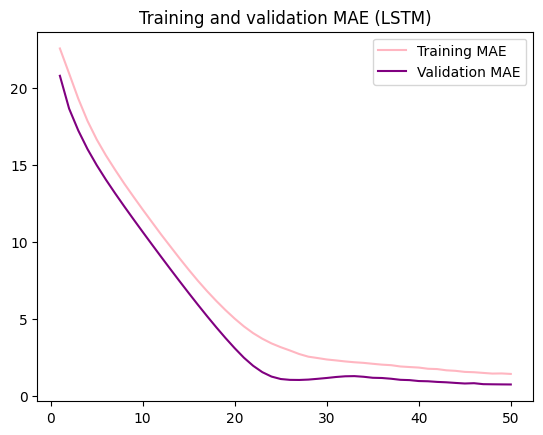

In [146]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "lightpink", label="Training MAE")
plt.plot(epochs, val_loss, "purple", label="Validation MAE")
plt.title("Training and validation MAE (LSTM)")
plt.legend()
plt.show()


## Prediction 


In [147]:

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=price[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


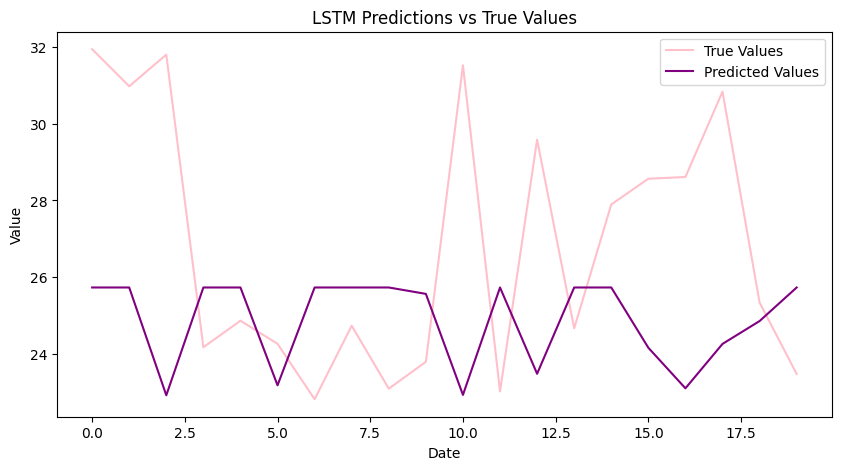

In [148]:
# Predict using the trained model
predictions = model.predict(test_dataset)

# Extract true values for plotting (optional: flatten to 1D if needed)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_true[20:40], label='True Values', color='pink')
plt.plot(predictions[20:40], label='Predicted Values', color='purple')
plt.title('LSTM Predictions vs True Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Punto 3